In [ ]:
# =============================================================================
# BMED318 Medical Image Processing: Hands-On for Image Reconstruction
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as tr
from scipy.ndimage import rotate
from numpy import fft

In [ ]:
# 1.1. Read the input file, sinogram.bmp. This sinogram was acquired by PET scan from 0° to 180° of ratation (0 ≤ θ < π). 
image = plt.imread('sinogram.bmp')
    
# 1.2. Frequency Filtering: Generate the ramp filter (|w|) in the frequency domain.
# For 0 ≤ θ < π, apply it to the 1D projection
num, length = image.shape
freqs = np.fft.fftfreq(length)
ramp_filter= np.abs(freqs)*2
filtered_image = np.zeros_like(image)

for i in range(num):
    projection = image[i,:]
    projection_fft = np.fft.fft(projection)
    filtered_fft = projection_fft*ramp_filter
    filtered_projection = np.real(np.fft.ifft(filtered_fft))
    filtered_image[i,:] = filtered_projection 
    
# 1.3. Backprojection: For 0 ≤ θ < π , generate the backprojected image at each θ from the filtered sinogram
# Explain how you chose the reconstructed image size.

image_size = length
reconstructed_image = np.zeros((image_size, image_size))
angles_deg = np.linspace(0, 180.0, num, endpoint=False)
for i in range(num):
    proj_row = filtered_image[i,:]
    back_projection_2d = np.tile(proj_row, (image_size, 1))
    rotated_image = rotate(back_projection_2d, angles_deg[i],
                           reshape=False, order=1, mode='constant', cval=0.0)
    reconstructed_image += rotated_image
    
# 1.4. Superposition: For 0 ≤ θ < π , accumulate the image to make the final reconstructed image 

reconstructed_image = reconstructed_image*np.pi / (2*num)

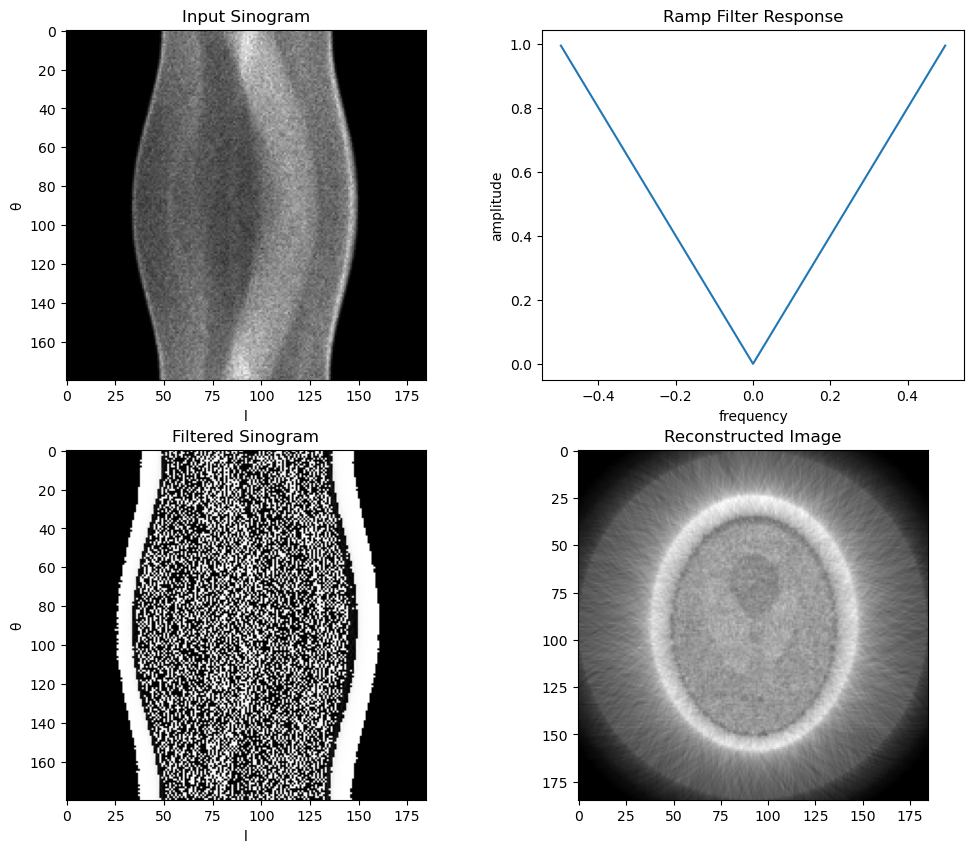

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1); plt.imshow(image, cmap='gray')
plt.title('Input Sinogram'); plt.xlabel('l'); plt.ylabel('θ')

plt.subplot(2,2,2); plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(ramp_filter))
plt.title('Ramp Filter Response'); plt.xlabel('frequency'); plt.ylabel('amplitude')

plt.subplot(2,2,3); plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Sinogram'); plt.xlabel('l'); plt.ylabel('θ')

plt.subplot(2,2,4); plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image');

plt.show()

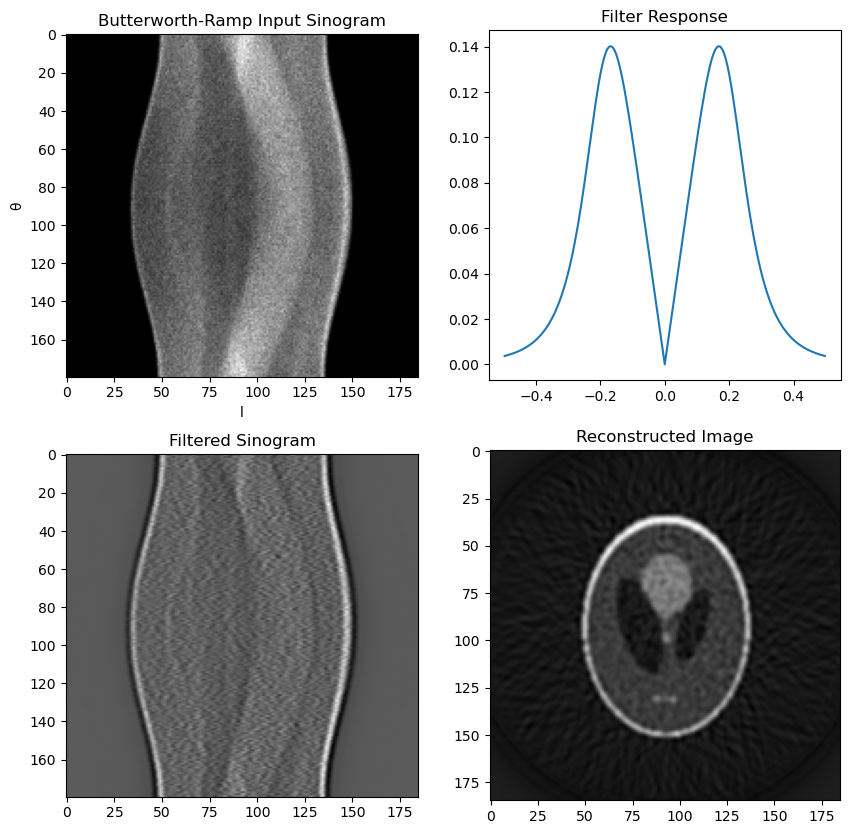

In [ ]:
# 2. Make functions for Prob 1. respectively.

def frequency_filter_projections(image, fc_ratio, n_order):
    num, length = image.shape
    freqs = np.fft.fftfreq(length)
    ramp_filter = np.abs(freqs)
    
    fc=fc_ratio*0.5
    if n_order>0:
        butterworth_lpf = 1.0/(1.0 + (np.abs(freqs)/fc)**(2*n_order))
    else:
        butterworth_lpf = 1.0
    
    final_filter = ramp_filter*butterworth_lpf
    
    projections_fft = np.fft.fft(image, axis=1)
    filtered_fft = projections_fft * final_filter
    filtered_image = np.real(np.fft.ifft(filtered_fft, axis=1))
    return filtered_image, final_filter
    

    


def backproject(filtered_image):
    num, length = filtered_image.shape
    image_size = length
    reconstructed_image = np.zeros((image_size, image_size))
    angles_deg = np.linspace(0, 180.0, num, endpoint=False)
    
    for i in range(num):
        proj_row = filtered_image[i,:]
        back_projection_2d = np.tile(proj_row, (image_size,1))
        rotated_image = rotate(back_projection_2d, angles_deg[i],
                               reshape=False, order=1, mode='constant', cval=0.0)
        
        reconstructed_image += rotated_image
    reconstructed_image = reconstructed_image*np.pi / (2*num)
    return reconstructed_image



def plot_results(sinogram, filtered_sinogram, filter_response, reconstructed_image, title_prefix):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1); plt.imshow(sinogram, cmap='gray')
    plt.title(f'{title_prefix} Input Sinogram'); plt.xlabel('l'); plt.ylabel('θ')
    
    length = len(filter_response); freqs = np.fft.fftfreq(length)
    freqs_viz = np.fft.fftshift(freqs); shifted_filter_viz = np.fft.fftshift(filter_response)
    plt.subplot(2,2,2); plt.plot(freqs_viz, shifted_filter_viz)
    plt.title('Filter Response'); 

    plt.subplot(2,2,3); plt.imshow(filtered_sinogram, cmap='gray')
    plt.title('Filtered Sinogram'); 

    plt.subplot(2,2,4); plt.imshow(reconstructed_image, cmap='gray')
    plt.title('Reconstructed Image');

    plt.show()

# For now, replace the ramp filter with the bandpass filter below (ramp followed by butterworth LPF).
# Try different cutoff frequencies to get the best quality in your subjective observation.
# Describe the reason why you chose those cutoff frequencies. Compare the results with ramp filter.
# Discuss the results in terms of how the filter impact the quality of reconstructed image. 

# 2.2 Butterworth-Ramp 필터 생성
# B(f) = 1 / [1 + (f / fc)^(2n)] [cite: 54]

# 파라미터 설정
fc_ratio = 0.44  # 컷오프 주파수 비율 (0.1 ~ 1.0)
n_order = 3     # 필터 차수 (e.g., 3)

filtered_sino, filter_curve = frequency_filter_projections(image, fc_ratio, n_order)
recon_butterworth = backproject(filtered_sino)
plot_results(image, filtered_sino, filter_curve, recon_butterworth, "Butterworth-Ramp")

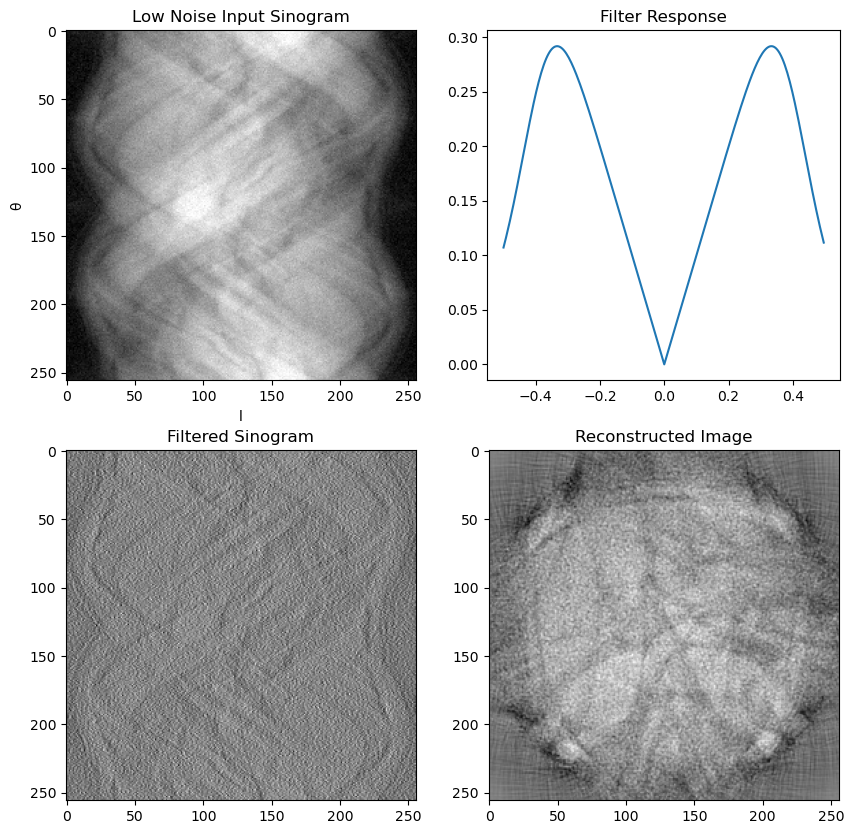

In [ ]:
# Try to find the best filter parameters for each case.  

# 3.1.
sino_low = plt.imread('sinogram_lownoise.png')
filtered_sino_low, filter_curve_low = frequency_filter_projections(sino_low,
                                                                   fc_ratio=0.85,
                                                                   n_order=4)
recon_low = backproject(filtered_sino_low)
plot_results(sino_low, filtered_sino_low, filter_curve_low, recon_low, "Low Noise")

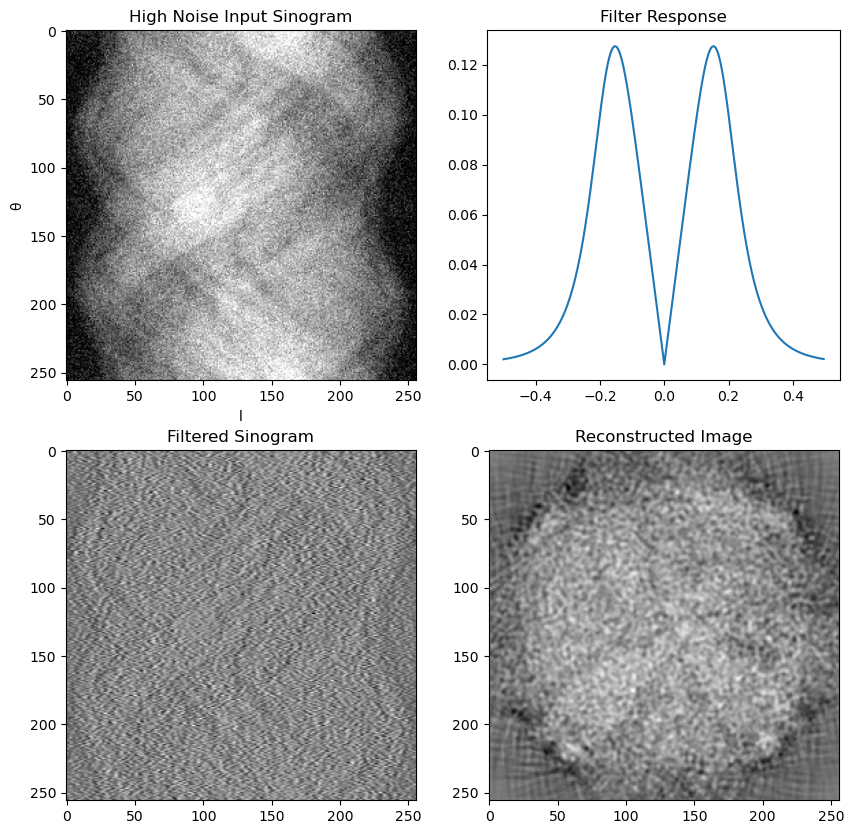

In [ ]:
sino_high = plt.imread('sinogram_highnoise.png')
filtered_sino_high, filter_curve_high = frequency_filter_projections(sino_high,
                                                                   fc_ratio=0.4,
                                                                   n_order=3)
recon_high = backproject(filtered_sino_high)

plot_results(sino_high, filtered_sino_high, filter_curve_high, recon_high, "High Noise")